In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
from os import listdir
import json

In [62]:
# Import data

# Los datos son del 
# 1 al 11 de mayo de 2016 y de
# 11 al 30 de abril de 2016

# File structure: 
# hora, valorDemanda, valorPronostico, valorGeneracion

data_files = listdir("data") # Folder where the files were extracted
all_data_sin = pd.DataFrame()
for dfile in data_files:
    day = dfile[:10] # get date from filename
    fd = open('data/' + dfile)
    contents = fd.read()
    fd.close()
    partial = pd.read_json(contents) # read into df
    partial = partial.drop('valorEnlace', 1) # remove valorEnlace col (all nulls)
    partial['hora'] = partial['hora'].apply(str)
    partial.at[23, 'hora'] = '00' # 24 is not a valid hour value
    day_arr = [day] * len(partial)
    partial['day'] = day_arr
    partial['hora'] = partial['hora'].apply(lambda x: '0'+x if len(x) < 2 else x)
    partial['date'] = partial['day'] + partial['hora']
    partial['date'] = partial['date'].apply(lambda x: pd.to_datetime(x, format="%d.%m.%Y%H"))
    partial = partial.drop(['day', 'hora'], 1)
    all_data_sin = all_data_sin.append(partial, ignore_index = True)

In [252]:
def subset_by_date_range(dataset, lower, upper):
    return dataset[(dataset.date >= pd.to_datetime(lower)) & (dataset.date < pd.to_datetime(upper))]

## Descriptive Data

- Como varia la demanda durante la semana?
- Cuales son las horas pico?
- Cuales son los días pico?
- Ves alguna relación entre el pronostico y la demanda? Entre la demanda y la generación?

In [78]:
all_data_sin = all_data_sin[all_data_sin.valorDemanda != ' ']

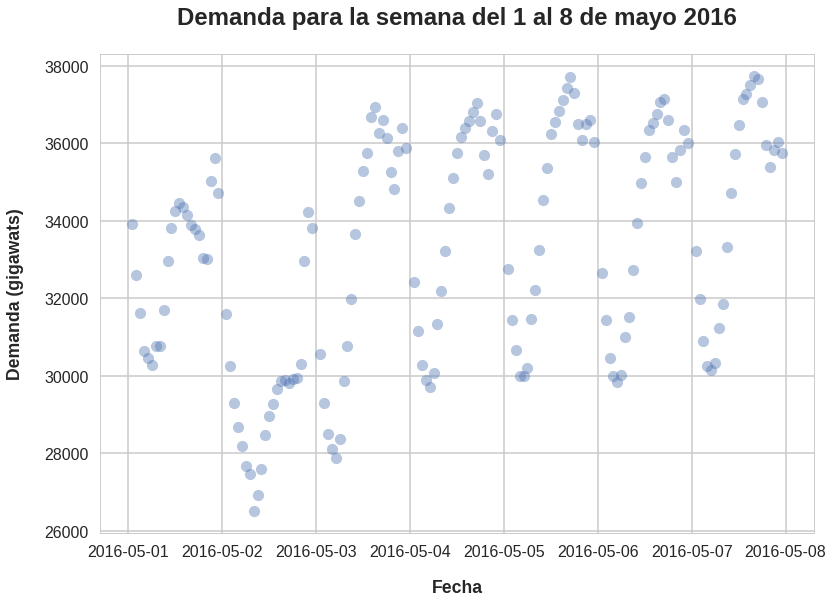

In [253]:
week1 = subset_by_date_range(all_data_sin, '2016-05-01', '2016-05-08')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Demanda para la semana del 1 al 8 de mayo 2016')
ax.title.set_position([.5, 1.05])
ax.title.set_size(24)
ax.title.set_weight('bold')
ax.yaxis.labelpad =20
ax.yaxis.label.set_weight('bold')
ax.set_ylabel('Demanda (gigawats)')
ax.set_xlabel('Fecha')
ax.xaxis.label.set_weight('bold')
ax.xaxis.labelpad =20
ax.plot_date(week1['date'].values, week1['valorDemanda'].values, 'o', alpha = .4)


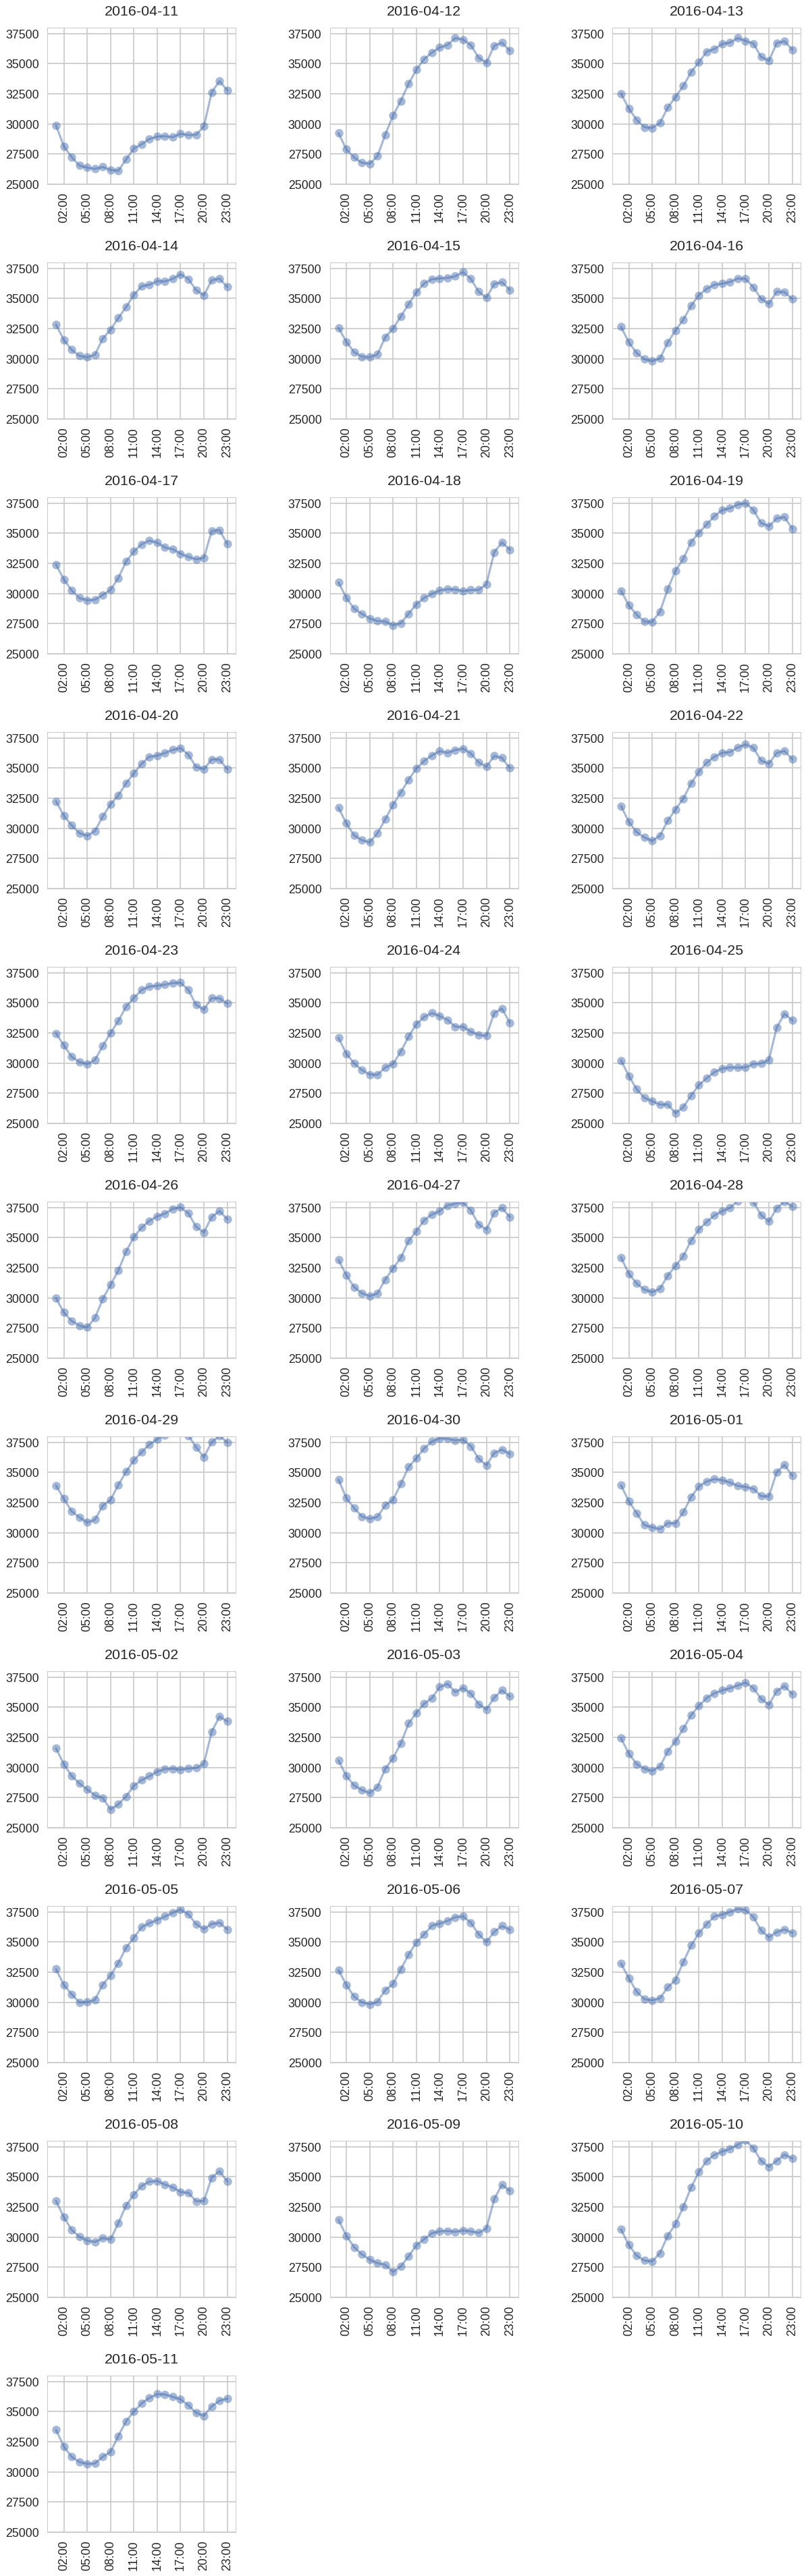

In [349]:
start_date = pd.to_datetime('2016-04-11')
fig = plt.figure(figsize=(18,80), dpi= 80, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.5, wspace=.5)
day = start_date
from matplotlib import dates
for i in range(31): # cambiar este parametro a 31 para el set completo
    tomorrow = day + DateOffset(days = 1)
    next_week = week_date + DateOffset(days = 7)
    s_data = subset_by_date_range(all_data_sin, day, tomorrow)
    if(len(s_data) == 0):
        day = day + DateOffset(days = 1)
        continue
    ax = fig.add_subplot(11, 3, i+1)
    ax.set_title(str(day)[:10])
    ax.set_ylim(bottom=25000, top=38000)
    hfmt = dates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(hfmt)
    ax.title.set_position([.5, 1.05])
    plt.xticks(rotation='vertical')
    plt.subplots_adjust(bottom=.3)
    ax.plot_date(s_data['date'].values, s_data['valorDemanda'].values, 'o-', alpha = 0.5)
    day = day + DateOffset(days = 1)

## Rango

Es interesante cómo el rango es bastante variable de día a día. Podemos ver cómo se comporta en las siguientes gráficas

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot_date()

## Consumo promedio por semana

In [284]:
def summarise_week(week1):
    week1.valorDemanda = week1.valorDemanda.astype(int)
    week1.valorGeneracion = week1.valorGeneracion.astype(int)
    day1 = week1.sort_values(by = 'date').iloc[0]['date']
    date_data = subset_by_date_range(week1, day1, day1 + DateOffset(days=1))
    summary_df = pd.DataFrame()
    while(len(date_data) != 0):
        p = [{'date':day1, 'meanDemand': date_data.valorDemanda.mean()}]
        summary_df = summary_df.append(pd.DataFrame(p), ignore_index = True)
        day1 = day1 + DateOffset(days=1)
        date_data = subset_by_date_range(week1, day1, day1 + DateOffset(days=1))
    return summary_df

In [357]:
def plot_week_demand(week1):
    week_summary = summarise_week(week1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_ylim([28500, 35000])
    ax.set_title('Demanda de energia por semana: del 1 al 8 de mayo de 2016') # cambiar el titulo
    ax.title.set_size(24)
    ax.title.set_weight('bold')
    ax.set_ylabel('Demanda (gigawats)')
    ax.title.set_position([.5, 1.05])
    ax.set_xlabel('Fecha')
    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 20
    ax.bar(week_summary['date'].values, week_summary['meanDemand'].values, width=.7)
    ax.xaxis_date()


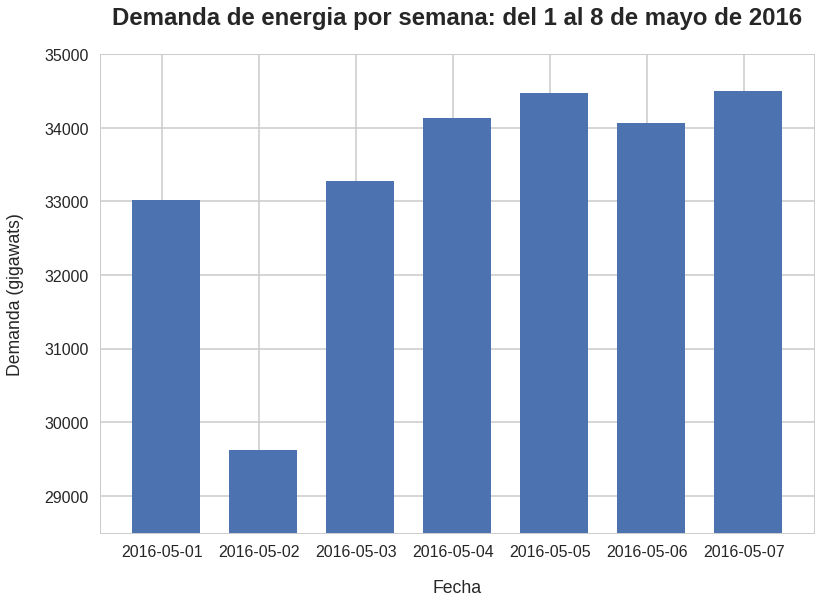

In [358]:
plot_week_demand(week1)

Aquí es interesante ver el bajo consumo que hay el 02 de mayo (Lunes) y cómo el fin de semana (jueves, viernes y sábado) representan los consumos más grandes

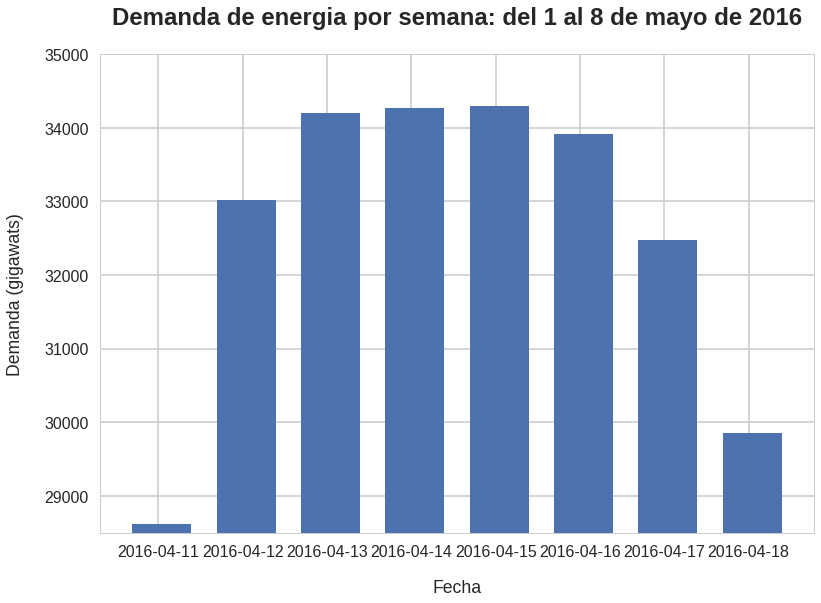

In [352]:
plot_week_demand(subset_by_date_range(all_data_sin, '2016-04-11', '2016-04-19'))

En esta gráfica del 11 (lunes) al 18 de abril podemos ver que la tendencia se mantiene (i.e. los **Lunes** son los días con menos demanda de energía), mientras que jueves y viernes son los días donde hay mayor demanda.

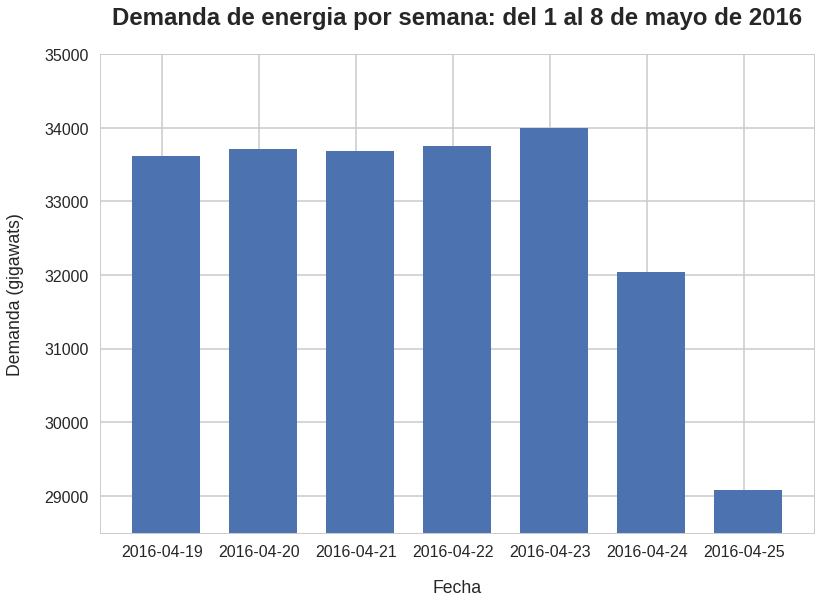

In [354]:
plot_week_demand(subset_by_date_range(all_data_sin, '2016-04-19', '2016-04-26'))